<a href="https://colab.research.google.com/github/sensei-jirving/Online-DS-PT-01.24.22-cohort-notes/blob/main/Week_08/Lecture_02/Challenge/SOLUTIONS_Challenge_Boosting_Titantic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Boosting Live Class Challenge Sample Solutions

This is the famous Titanic Dataset. We are predicting whether the passengers survived or died based on the features given.

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, recall_score, precision_score, \
f1_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

In [11]:
# Define a function that takes in arguments and prints out a classification report, confusion matrix and ROC AUC
def evaluate_classification(model, X_test, y_test, cmap=None,
                            normalize='true', classes=None, figsize=(20,5)):
  test_preds = model.predict(X_test)
  print(metrics.classification_report(y_test, test_preds, target_names=classes))

  fig, ax = plt.subplots(ncols=3, figsize=figsize)
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Greens',
                                        display_labels=classes,
                                        ax=ax[0])
  
  ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
                                        display_labels=classes, normalize='true',
                                        ax=ax[1])
  
  curve = metrics.plot_roc_curve(model, X_test, y_test, ax=ax[2])
  curve.ax_.grid()
  curve.ax_.plot([0, 1], [0, 1], ls=':')

## Load and examine data

In [12]:
df = pd.read_csv('/content/drive/MyDrive/Coding Dojo/Lectures - Live Class Materials/Stack 2/Week 5/Titanic.csv')

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   sex          891 non-null    object 
 4   age          714 non-null    float64
 5   sibsp        891 non-null    int64  
 6   parch        891 non-null    int64  
 7   fare         891 non-null    float64
 8   embarked     889 non-null    object 
 9   class        891 non-null    object 
 10  who          891 non-null    object 
 11  deck         203 non-null    object 
 12  embark_town  889 non-null    object 
 13  alive        891 non-null    object 
dtypes: float64(2), int64(5), object(7)
memory usage: 97.6+ KB


In [14]:
df.head()

,Unnamed: 0,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,deck,embark_town,alive
0,0,0,3,male,22.0,1,0,7.2500,S,Third,man,NaN,Southampton,no
1,1,1,1,female,38.0,1,0,71.2833,C,First,woman,C,Cherbourg,yes
2,2,1,3,female,26.0,0,0,7.9250,S,Third,woman,NaN,Southampton,yes
3,3,1,1,female,35.0,1,0,53.1000,S,First,woman,C,Southampton,yes
4,4,0,3,male,35.0,0,0,8.0500,S,Third,man,NaN,Southampton,no


In [15]:
df.duplicated().sum()

0

Use a seaborn pairplot to examine the distributions of and correlations between columns (distributions are on the diagonal)

In [16]:
df.describe()

,Unnamed: 0,survived,pclass,age,sibsp,parch,fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,445.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,222.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,445.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,667.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,890.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


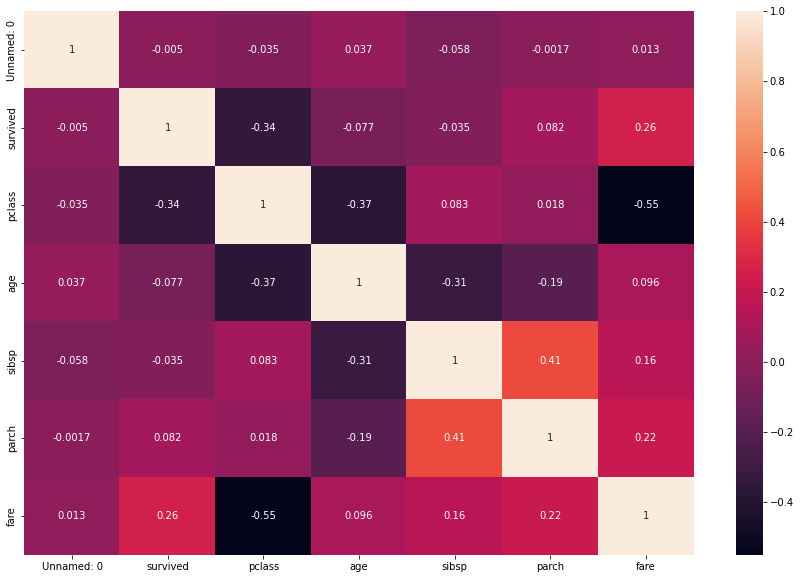

In [17]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, ax=ax)

# Class Balance



In [18]:
df['survived'].value_counts()

0    549
1    342
Name: survived, dtype: int64

In [19]:
#Split the data into training and validation sets
X = df.drop(columns=['survived', 'Unnamed: 0', 'alive', 'who', 'embarked'])
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Preprocessing Pipeline

A ColumnTransformer allows you to apply different preprocessing steps to different columns.  In this case we want to one-hot encode the categorical columns and scale the numeric columns.

A ColumnSelector returns certain columns based on their data type.  ColumnTransformer can also just take a list of column names instead if desired.

In [20]:
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore')
scaler = StandardScaler()

#column_selectors to tell the column transformers which columns to apply which preprocessing to
category_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number')

#imputers
mean_imputer = SimpleImputer(strategy = 'mean')
freq_imputer = SimpleImputer(strategy = 'most_frequent')

num_pipe = make_pipeline(mean_imputer, scaler)
freq_pipe = make_pipeline(freq_imputer, ohe)

num_tuple = (num_pipe, number_selector)
freq_tuple = (freq_pipe, category_selector)

#column transformer
column_transformer = make_column_transformer(freq_tuple, num_tuple, remainder='passthrough')

# Adaboost

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       134
           1       0.75      0.75      0.75        89

    accuracy                           0.80       223
   macro avg       0.79      0.79      0.79       223
weighted avg       0.80      0.80      0.80       223



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


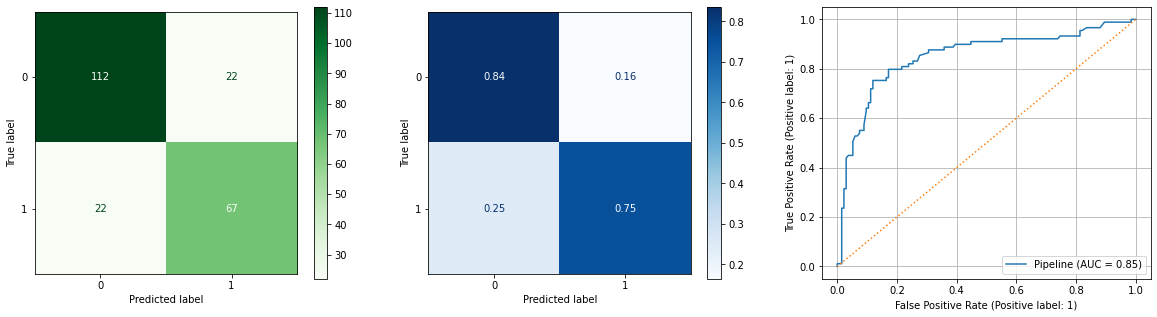

In [21]:
ada_pipe = make_pipeline(column_transformer, AdaBoostClassifier())
ada_pipe.fit(X_train, y_train)

evaluate_classification(ada_pipe, X_test, y_test)

# Light GBM

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       134
           1       0.78      0.75      0.77        89

    accuracy                           0.82       223
   macro avg       0.81      0.81      0.81       223
weighted avg       0.82      0.82      0.82       223



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


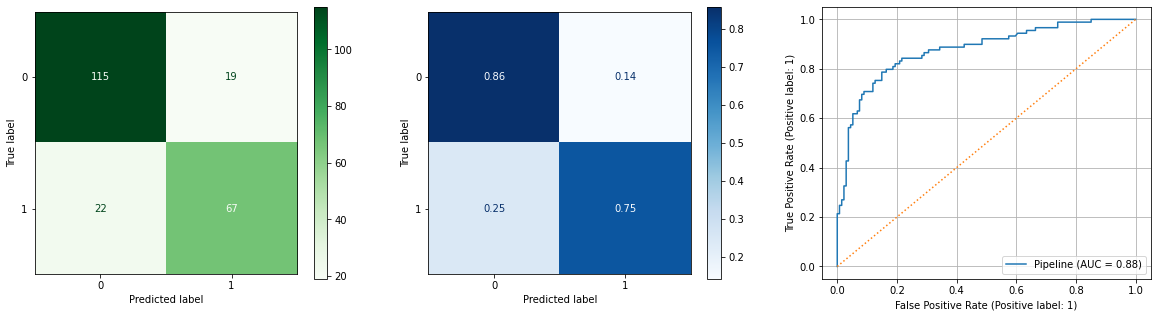

In [22]:
lgb_pipe = make_pipeline(column_transformer, LGBMClassifier())
lgb_pipe.fit(X_train, y_train)

evaluate_classification(lgb_pipe, X_test, y_test)

# XGBoost

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       134
           1       0.81      0.73      0.77        89

    accuracy                           0.83       223
   macro avg       0.82      0.81      0.81       223
weighted avg       0.82      0.83      0.82       223



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


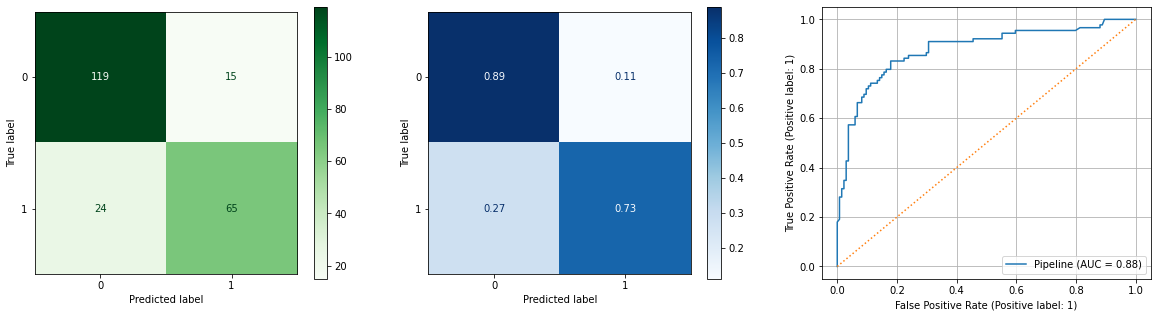

In [23]:
xgb_pipe = make_pipeline(column_transformer, XGBClassifier())
xgb_pipe.fit(X_train, y_train)

evaluate_classification(xgb_pipe, X_test, y_test)

# Evaluation:

1. Which metrics are most important for this business case?  

2. According to these metrics, what will this model be good at?  What will it be bad at?

# Next Steps:

What would you do next to make this model better?

1. 
2. 
3. 